In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
#from icecube import astro
import histlite as hl
import healpy
import socket
import pickle
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/review/sigsub_variance'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/review/sigsub_variance'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [10]:

class DNNCascade_10yr_Mod(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
    """Removed high-E, high-sigma Events"""
    def dataset_modifications(self, ds):
        """Remove events with high-E and high-sigma"""
        return # --- DONT DO ANYTHING!
        sig = copy.deepcopy(ds.sig)
        data = copy.deepcopy(ds.data)
        
        def create_mask(df):
            mask1 = np.logical_and(
                df.sigma > np.deg2rad(10),
                df.energy > 1e6,
            ) 
            mask2_1 = np.logical_and(
                df.energy > 1e5,
                df.energy < 1e6,
            ) 
            mask2 = np.logical_and(
                mask2_1,
                df.sigma > np.deg2rad(20),
            ) 
            return ~np.logical_or(mask1, mask2)
        
        ds.sig = sig[create_mask(sig)]
        ds.data = data[create_mask(data)]
    
    _kw_energy = dict (bins_energy=(), bins_sindec=np.linspace (-1, 1, 31))
    _bins_logenergy = np.linspace(np.log10(500), 8.01, 12)


#specs = [DNNCascade_10yr_Mod]

In [5]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86

In [6]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [7]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Check if background PDF captures energy dependence

(array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
         0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ]),
 array([2.        , 2.42928571, 2.85857143, 3.28785714, 3.71714286,
        4.14642857, 4.57571429, 5.005     , 5.43428571, 5.86357143,
        6.29285714, 6.72214286, 7.15142857, 7.58071429, 8.01      ]))

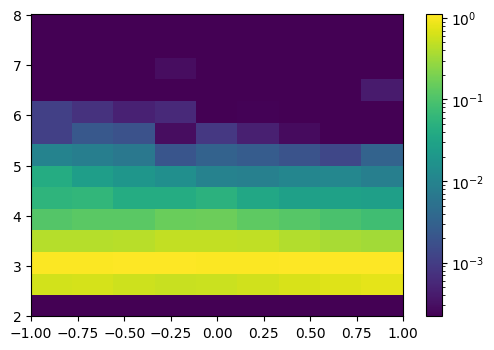

In [8]:
hl.plot2d(a.energy_pdf_ratio_model.h_bg, log=True, cbar=True)
a.energy_pdf_ratio_model.hkw['bins']

[0.22222222 0.22222222 0.22222222]
Normalization:  7.41827371651169
Normalization:  10.482529118136439
Scaling p_calc
Normalization:  10.482529118136446
Normalization:  10.482529118136439


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This 

Text(0.5, 1.0, '$\\frac{P(E, \\sin\\delta)}{P(\\sin\\delta) * P(E | \\sin\\delta)}$')

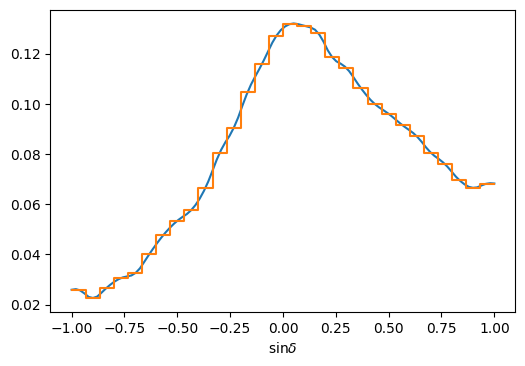

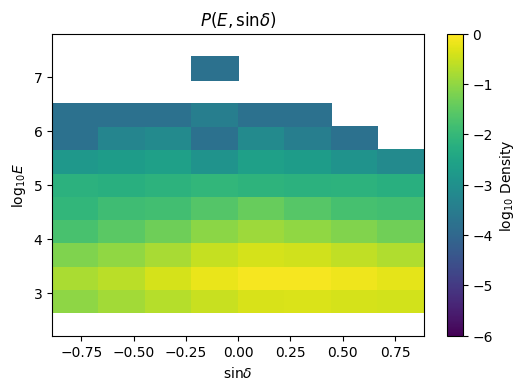

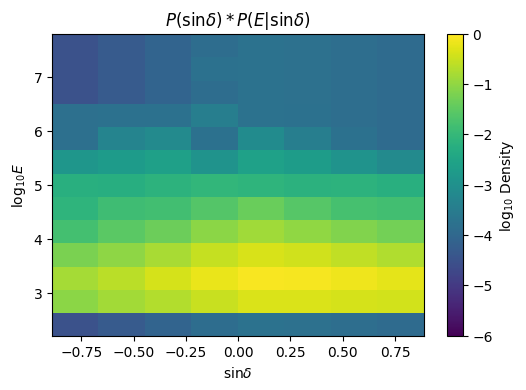

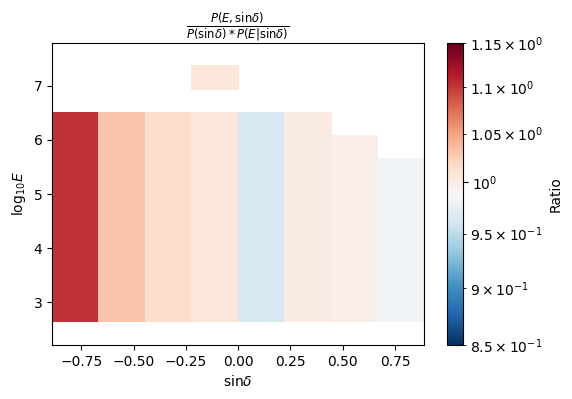

In [9]:
a.bg_space_param.s(.4)
x = np.linspace(-1, 1, 100)

def pdf_sindec(sindec):
    return np.exp(a.bg_space_param.s(sindec))

fig, ax = plt.subplots()
ax.plot(x, pdf_sindec(x))
hl.plot1d(ax, a.bg_space_param.h, cbar=True, log=True)
ax.set_xlabel('$\sin{\delta}$')

bins = a.energy_pdf_ratio_model.hkw['bins']
xmids = bins[0][:-1] + 0.5 * np.diff(bins[0])
ymids = bins[1][:-1] + 0.5 * np.diff(bins[1])

# calculate p(sindec) * p(E|sindec)
sindec_width = np.diff(bins[0])
print(np.unique(sindec_width))
assert np.allclose(sindec_width, sindec_width[0])
sindec_width = sindec_width[0]
p_calc = a.energy_pdf_ratio_model.h_bg.values * np.expand_dims(pdf_sindec(xmids), axis=-1) / sindec_width


fig, ax = plt.subplots()
h, xedges, yedges = np.histogram2d(
    a.bg_data.sindec, a.bg_data.log10energy, bins=bins, density=True)

xx, yy = np.meshgrid(xmids, ymids)

print('Normalization: ', np.sum(p_calc))
print('Normalization: ', np.sum(h))
if True:
    print('Scaling p_calc')
    p_calc /= np.sum(p_calc) / np.sum(h)
    print('Normalization: ', np.sum(p_calc))
    print('Normalization: ', np.sum(h))

vmin = -6
vmax = 0
im = ax.pcolormesh(xx, yy, np.log10(h.T), vmin=vmin, vmax=vmax)
ax.set_xlabel('$\sin{\delta}$')
ax.set_ylabel('$\log_{10} E$')
cb =plt.colorbar(im, ax=ax)
cb.set_label('$\log_{10}$ Density')
ax.set_title('$P(E, \sin\delta)$')

fig, ax = plt.subplots()
im = ax.pcolormesh(xx, yy, np.log10(p_calc.T), vmin=vmin, vmax=vmax)
ax.set_xlabel('$\sin{\delta}$')
ax.set_ylabel('$\log_{10} E$')
cb =plt.colorbar(im, ax=ax)
cb.set_label('$\log_{10}$ Density')
ax.set_title('$P(\sin\delta) * P(E | \sin\delta)$')


fig, ax = plt.subplots()
#im = ax.pcolormesh(xx, yy, np.log10( h.T / p_calc.T))
im = ax.pcolormesh(xx, yy, h.T / p_calc.T, norm=mpl.colors.LogNorm(vmin=0.85, vmax=1.15), cmap='RdBu_r')
ax.set_xlabel('$\sin{\delta}$')
ax.set_ylabel('$\log_{10} E$')
cb = plt.colorbar(im, ax=ax)
#cb.set_label('$\log_{10}$ Ratio')
cb.set_label('Ratio')
ax.set_title(r'$\frac{P(E, \sin\delta)}{P(\sin\delta) * P(E | \sin\delta)}$')


## Setup Analysis

In [78]:
def get_catalog_tr(catalog, gamma, cpus, cutoff_TeV=np.inf, sigsub=True):
    
    catalog = catalog.lower()
    if catalog not in ['snr', 'pwn', 'unid']:
        raise ValueError('Catalog not understood: {}'.format(catalog))
    
    # get catalog and sources
    cat = np.load('../../catalogs/{}_ESTES_12.pickle'.format(catalog),
        allow_pickle=True)
    src = cy.utils.Sources(dec=cat['dec_deg'], ra=cat['ra_deg'], deg=True)
        
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8)
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_catalog_tr_no_sigsub(*args, **kwargs):
    if 'sigsub' in kwargs: raise KeyError('sigsub is defined!')
    return get_catalog_tr(*args, sigsub=False, **kwargs)

def get_trial_runner(sindec, gamma, cpus, ra=0., cutoff_TeV=np.inf, sigsub=True):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8)
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_trial_runner_no_sigsub(*args, **kwargs):
    if 'sigsub' in kwargs: raise KeyError('sigsub is defined!')
    return get_trial_runner(*args, sigsub=False, **kwargs)

def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt


### Plotting Helpers

In [79]:

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()


## Test Bias

#### Point Source

In [ ]:
%%time

mp_cpus = 20
fit_gamma = True

runners_to_check = [
    (get_trial_runner_no_sigsub, f'$\Psi$ * E [no sigsub]'),
    (get_trial_runner, f'$\Psi$ * E'),
]

for tr_gamma in [2., 2.5, 3.]:
#for tr_gamma in [2]:
    #for sindec in np.linspace(-0.99, 0.99, 20):
    #for sindec in [ 0, .4]:
    #for sindec in [-.95]:
    #for sindec in [-.8, -.4, 0, .4, .8]:
    for sindec in [-.95, -.8, -.6, -.4, -.2, 0, .2, .4, .6, .8, .95]:
    #for sindec in [0]:
        print(f'sindec = {sindec} | gamma = {tr_gamma} ...')
        
        if fit_gamma:
            fig, axes = plt.subplots(1, 2)
        else:
            fig, ax = plt.subplots(1, 1)
        for trial_run_func, label in runners_to_check:
            trial_runner, src = trial_run_func(
                sindec, gamma=tr_gamma, cpus=mp_cpus)
            allt_i = get_bias_allt(
                trial_runner, ntrials=200, n_sigs=np.r_[:int(120*tr_gamma):int(8*tr_gamma)])
            if fit_gamma:
                plot_ns_bias(axes[0], trial_runner, allt_i, label=label)
                plot_gamma_bias(axes[1], trial_runner, allt_i, label=label)
            else:
                plot_ns_bias(ax, trial_runner, allt_i, label=label)
        if fit_gamma:
            axes[0].set(title=rf'$\sin(\delta)={sindec:+.2f}$ | $\gamma={tr_gamma}$')
            axes[1].legend(fontsize=8)
        else:
            ax.set(title=rf'$\sin(\delta)={sindec:+.2f}$ | fixed $\gamma={tr_gamma}$')
            ax.legend(fontsize=8)
        fig.tight_layout()
        fig.savefig('{}/bias_sindec{:2.2f}_gamma{:2.2f}.png'.format(
            plot_dir, sindec, tr_gamma))


#### Stacking Searches

In [ ]:
%%time

mp_cpus = 25
fit_gamma = True

runners_to_check = [
    (get_catalog_tr_no_sigsub, f'$\Psi$ * E [no sigsub]'),
    (get_catalog_tr, f'$\Psi$ * E'),
]

for tr_gamma in [2., 2.5, 3.]:
    for catalog in ['pwn', 'unid', 'snr']:
        print(f'catalog = {catalog} | gamma = {tr_gamma} ...')
        
        if fit_gamma:
            fig, axes = plt.subplots(1, 2)
        else:
            fig, ax = plt.subplots(1, 1)
        for trial_run_func, label in runners_to_check:
            trial_runner, src = trial_run_func(
                catalog=catalog, gamma=tr_gamma, cpus=mp_cpus)
            allt_i = get_bias_allt(
                trial_runner, ntrials=200, n_sigs=np.r_[:int(120*tr_gamma):int(8*tr_gamma)])
            if fit_gamma:
                plot_ns_bias(axes[0], trial_runner, allt_i, label=label)
                plot_gamma_bias(axes[1], trial_runner, allt_i, label=label)
            else:
                plot_ns_bias(ax, trial_runner, allt_i, label=label)
        if fit_gamma:
            axes[0].set(title=rf'catalog: {catalog} $\gamma={tr_gamma}$')
            axes[1].legend(fontsize=8)
        else:
            ax.set(title=rf'catalog: {catalog} | fixed $\gamma={tr_gamma}$')
            ax.legend(fontsize=8)
        fig.tight_layout()
        fig.savefig('{}/bias_catalog_{}_gamma{:2.2f}.png'.format(
            plot_dir, catalog, tr_gamma))


catalog = pwn | gamma = 2.0 ...
 224 ...
 224 ...
catalog = unid | gamma = 2.0 ...
 224 ...
 224 ...
catalog = snr | gamma = 2.0 ...
 224 ...
 224 ...
catalog = pwn | gamma = 2.5 ...
 280 ...
 280 ...
catalog = unid | gamma = 2.5 ...
 280 ...
 280 ...
catalog = snr | gamma = 2.5 ...
 280 ...
 280 ...
catalog = pwn | gamma = 3.0 ...
 336 ...
 336 ...
catalog = unid | gamma = 3.0 ...
 336 ...
 336 ...
catalog = snr | gamma = 3.0 ...
 336 ...
 264 ...

## Test Sources

In [52]:
from cycler import cycle

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color_cycler():
    return cycle(colors)


def test_source(
            ra, dec, E2dNdE, E0, unit, gamma, 
            cutoff_TeV=np.inf, sigsub=True, cpus=15, 
            n_bg_trials=100000, 
            n_sig_trials=10000, 
            deg=True
        ):
    
    if deg:
        ra = np.deg2rad(ra)
        dec = np.deg2rad(dec)
    sindec = np.sin(dec)
    
    # get trial runner
    trial_runner, src = get_trial_runner(
        sindec, ra=ra, gamma=gamma, sigsub=sigsub, cpus=cpus, cutoff_TeV=cutoff_TeV)
    
    # compute expected number of events for given flux
    n_expected = trial_runner.to_ns(E2dNdE=E2dNdE, E0=E0, unit=unit) # units are for both E0 and dE 
    print('Number of expected signal events: {}'.format(n_expected))
    
    # get background trials
    print('Performing BG Trials at RA: {}, DEC: {}'.format(src.ra_deg, src.dec_deg))
    bg = cy.dists.Chi2TSD(trial_runner.get_many_fits(n_trials=n_bg_trials, cpus=cpus))
    
    # get signal trials
    print('Performing Signal Trials at RA: {}, DEC: {}'.format(src.ra_deg, src.dec_deg))
    sig_trials = trial_runner.get_many_fits(n_trials=n_sig_trials, cpus=cpus, n_sig=n_expected, poisson=True)
    
    # compute significance
    p_values = bg.sf(sig_trials.ts)
    n_sigma = bg.sf_nsigma(sig_trials.ts)
    
    return sig_trials, bg, p_values, n_sigma, n_expected
        

### Define Sources

In [68]:
source_dict = {}
source_dict_no_ss = {}

for sindec in [-.95, -.8, -.6, -.4, -.2, 0, .2, .4, .6, .8, .95]:
#for sindec in [-.4]:
    for source_d, sigsub in zip([source_dict, source_dict_no_ss], [True, False]):
        source_d['sindec {:3.2f} 4 x NGC 1068 flux'.format(sindec)] = {
            'ra': 40.67,
            'dec': np.rad2deg(np.arcsin(sindec)), # -0.01,
            'gamma': 3.19,
            'E2dNdE': 4 * 5e-11,
            'E0': 1,
            'unit': 1000,
            'sigsub': sigsub,
        }
        
        source_d['sindec {:3.2f} 4 x TXS 0506+056 flux'.format(sindec)] = {
            'ra': 77.36,
            'dec': np.rad2deg(np.arcsin(sindec)), # 5.70,
            'gamma': 2.0,
            'E2dNdE': 4 * 0.8e-12,
            'E0': 100,
            'unit': 1000,
            'sigsub': sigsub,
        }

print('Number of sources:', len(source_dict), len(source_dict_no_ss))

Number of sources: 22 22


### Run trials for each source

In [69]:
n_bg_trials = 10000
n_sig_trials = 10000
cpus = 25


In [70]:
results = {}
for name, cfg in source_dict.items():
    print('Running trials for: {}'.format(name))
    sig_tr_i, bg_i, p_values_i, n_sigma_i, n_expected_i = test_source(
        ra=cfg['ra'], dec=cfg['dec'], E2dNdE=cfg['E2dNdE'], E0=cfg['E0'], unit=cfg['unit'], gamma=cfg['gamma'],
        cpus=cpus, n_bg_trials=n_bg_trials, n_sig_trials=n_sig_trials,
        sigsub=cfg['sigsub'],
    )
    print()
    
    # save data
    results[name] = {
        'sig_trials': sig_tr_i,
        'bg_trials': bg_i,
        'p_values': p_values_i,
        'n_sigma': n_sigma_i,
        'n_expected': n_expected_i,
    }

    with open(os.path.join(plot_dir, 'trials.pkl'), 'wb') as f:
        pickle.dump(results, f, protocol=2)

Running trials for: sindec -0.95 4 x NGC 1068 flux
Number of expected signal events: 93.40786606614795
Performing BG Trials at RA: [40.67], DEC: [-71.80512766]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Performing Signal Trials at RA: [40.67], DEC: [-71.80512766]
Performing 10000 trials with n_sig = 93.408 (poisson) using 25 cores:
      10000/10000 trials complete.   

Running trials for: sindec -0.95 4 x TXS 0506+056 flux
Number of expected signal events: 21.06986325184743
Performing BG Trials at RA: [77.36], DEC: [-71.80512766]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Performing Signal Trials at RA: [77.36], DEC: [-71.80512766]
Performing 10000 trials with n_sig = 21.070 (poisson) using 25 cores:
      10000/10000 trials complete.   

Running trials for: sindec -0.80 4 x NGC 1068 flux
Number of expected signal events: 94.66972202783396
Performing BG Trials at RA: [40.67], DEC: [-53.13010235

      10000/10000 trials complete.   
Performing Signal Trials at RA: [77.36], DEC: [53.13010235]
Performing 10000 trials with n_sig = 19.320 (poisson) using 25 cores:
      10000/10000 trials complete.   

Running trials for: sindec 0.95 4 x NGC 1068 flux
Number of expected signal events: 217.1468249606442
Performing BG Trials at RA: [40.67], DEC: [71.80512766]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Performing Signal Trials at RA: [40.67], DEC: [71.80512766]
Performing 10000 trials with n_sig = 217.147 (poisson) using 25 cores:
      10000/10000 trials complete.   

Running trials for: sindec 0.95 4 x TXS 0506+056 flux
Number of expected signal events: 16.772492432633317
Performing BG Trials at RA: [77.36], DEC: [71.80512766]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Performing Signal Trials at RA: [77.36], DEC: [71.80512766]
Performing 10000 trials with n_sig = 16.772 (poisson) using 25 c

In [71]:
results_no_ss = {}
for name, cfg in source_dict_no_ss.items():
    print('Running trials for: {}'.format(name))
    sig_tr_i, bg_i, p_values_i, n_sigma_i, n_expected_i = test_source(
        ra=cfg['ra'], dec=cfg['dec'], E2dNdE=cfg['E2dNdE'], E0=cfg['E0'], unit=cfg['unit'], gamma=cfg['gamma'],
        cpus=cpus, n_bg_trials=n_bg_trials, n_sig_trials=n_sig_trials,
        sigsub=cfg['sigsub'],
    )
    print()
    
    # save data
    results_no_ss[name] = {
        'sig_trials': sig_tr_i,
        'bg_trials': bg_i,
        'p_values': p_values_i,
        'n_sigma': n_sigma_i,
        'n_expected': n_expected_i,
    }

    with open(os.path.join(plot_dir, 'trials_no_ss.pkl'), 'wb') as f:
        pickle.dump(results_no_ss, f, protocol=2)

Running trials for: sindec -0.95 4 x NGC 1068 flux
Number of expected signal events: 93.40786606614795
Performing BG Trials at RA: [40.67], DEC: [-71.80512766]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Performing Signal Trials at RA: [40.67], DEC: [-71.80512766]
Performing 10000 trials with n_sig = 93.408 (poisson) using 25 cores:
      10000/10000 trials complete.   

Running trials for: sindec -0.95 4 x TXS 0506+056 flux
Number of expected signal events: 21.06986325184743
Performing BG Trials at RA: [77.36], DEC: [-71.80512766]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Performing Signal Trials at RA: [77.36], DEC: [-71.80512766]
Performing 10000 trials with n_sig = 21.070 (poisson) using 25 cores:
      10000/10000 trials complete.   

Running trials for: sindec -0.80 4 x NGC 1068 flux
Number of expected signal events: 94.66972202783396
Performing BG Trials at RA: [40.67], DEC: [-53.13010235

      10000/10000 trials complete.   
Performing Signal Trials at RA: [77.36], DEC: [53.13010235]
Performing 10000 trials with n_sig = 19.320 (poisson) using 25 cores:
      10000/10000 trials complete.   

Running trials for: sindec 0.95 4 x NGC 1068 flux
Number of expected signal events: 217.1468249606442
Performing BG Trials at RA: [40.67], DEC: [71.80512766]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Performing Signal Trials at RA: [40.67], DEC: [71.80512766]
Performing 10000 trials with n_sig = 217.147 (poisson) using 25 cores:
      10000/10000 trials complete.   

Running trials for: sindec 0.95 4 x TXS 0506+056 flux
Number of expected signal events: 16.772492432633317
Performing BG Trials at RA: [77.36], DEC: [71.80512766]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Performing Signal Trials at RA: [77.36], DEC: [71.80512766]
Performing 10000 trials with n_sig = 16.772 (poisson) using 25 c

In [72]:
with open(os.path.join(plot_dir, 'trials.pkl'), 'rb') as f:
    results = pickle.load(f)
    
with open(os.path.join(plot_dir, 'trials_no_ss.pkl'), 'rb') as f:
    results_no_ss = pickle.load(f)

### Make Plots

sindec -0.95 4 x NGC 1068 flux
93 103
1708 3208


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to t

sindec -0.95 4 x TXS 0506+056 flux
4147 11
1702 3256
sindec -0.80 4 x NGC 1068 flux
65 269
1149 3464
sindec -0.80 4 x TXS 0506+056 flux
1355 16
1175 3503
sindec -0.60 4 x NGC 1068 flux
102 403
1221 3473
sindec -0.60 4 x TXS 0506+056 flux
1824 18
1191 3528
sindec -0.40 4 x NGC 1068 flux
66 399
693 3405
sindec -0.40 4 x TXS 0506+056 flux
1067 28
702 3462
sindec -0.20 4 x NGC 1068 flux
162 664
656 3387
sindec -0.20 4 x TXS 0506+056 flux
813 16
662 3388
sindec 0.00 4 x NGC 1068 flux
130 1174
1255 3123
sindec 0.00 4 x TXS 0506+056 flux
2984 30
1222 3208
sindec 0.20 4 x NGC 1068 flux
137 915
1230 3418
sindec 0.20 4 x TXS 0506+056 flux
2548 75
1293 3278
sindec 0.40 4 x NGC 1068 flux
32 431
890 3476
sindec 0.40 4 x TXS 0506+056 flux
1447 120
945 3442
sindec 0.60 4 x NGC 1068 flux
29 459
1013 3703
sindec 0.60 4 x TXS 0506+056 flux
2347 306
1010 3823
sindec 0.80 4 x NGC 1068 flux
13 367
1529 3503
sindec 0.80 4 x TXS 0506+056 flux
2818 521
1528 3555
sindec 0.95 4 x NGC 1068 flux
25 301
1722 3333


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sindec 0.95 4 x TXS 0506+056 flux
1277 836
1703 3345


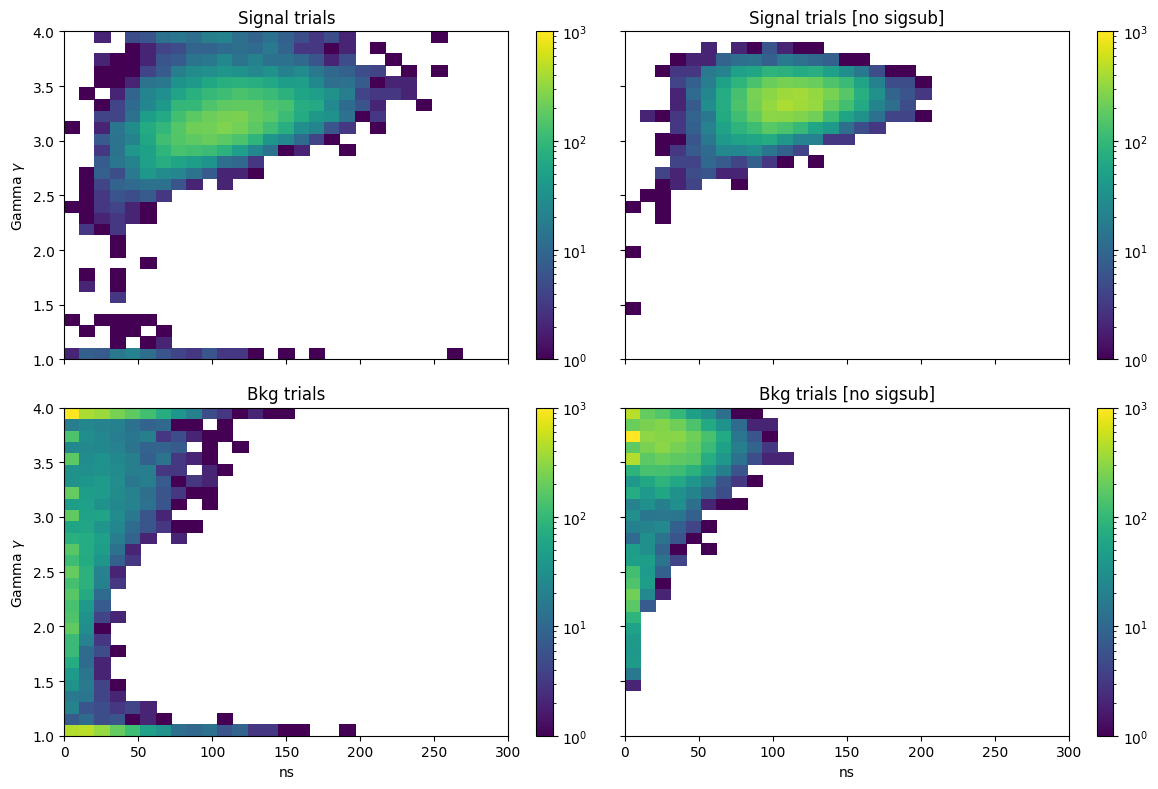

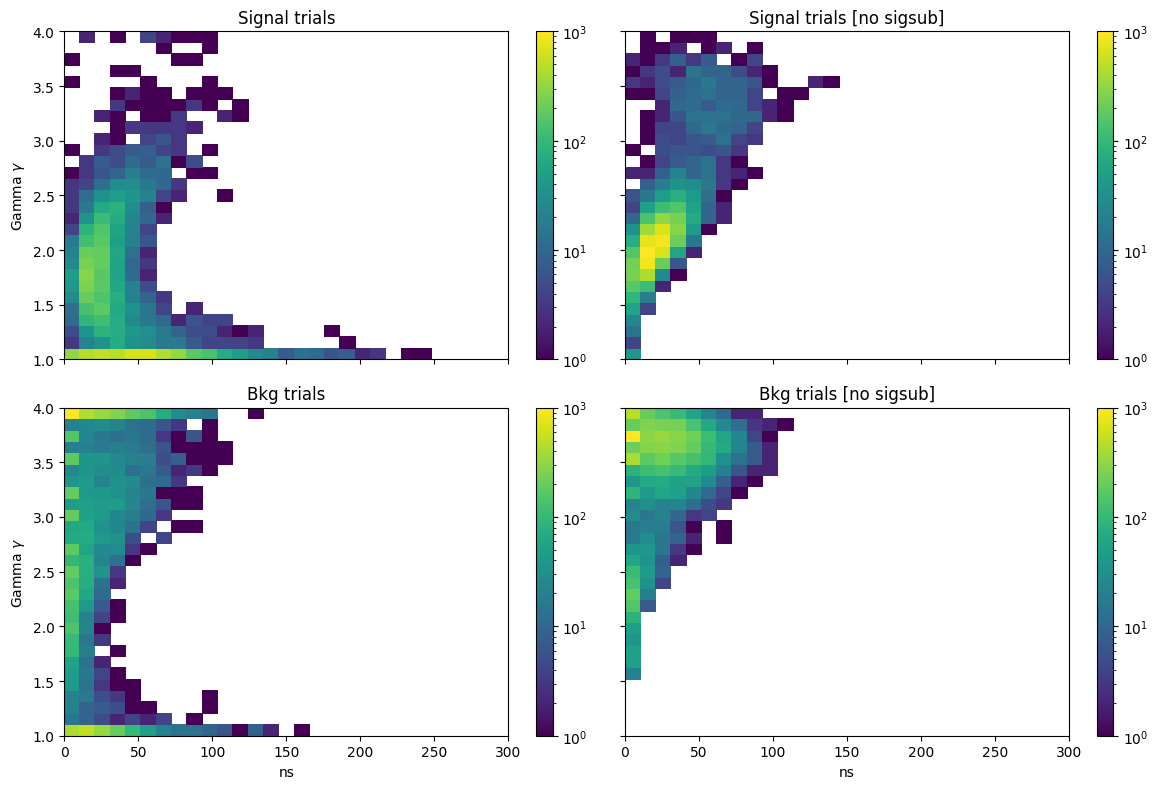

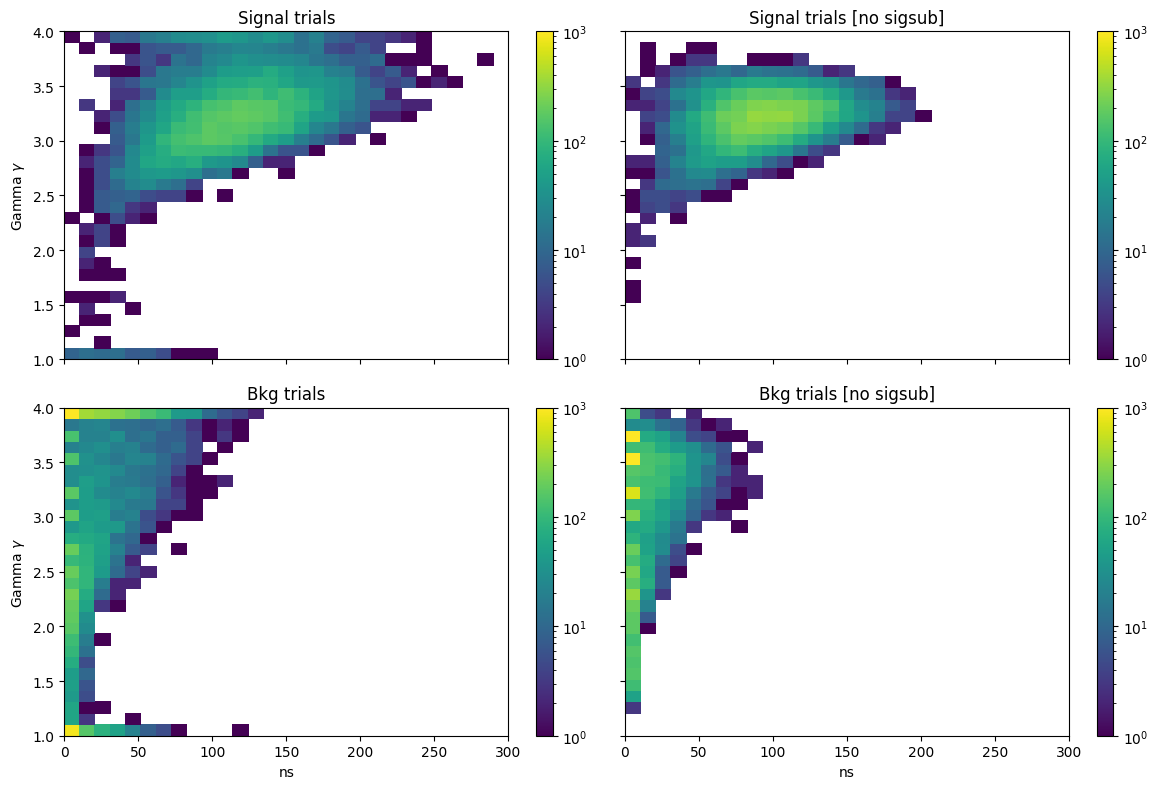

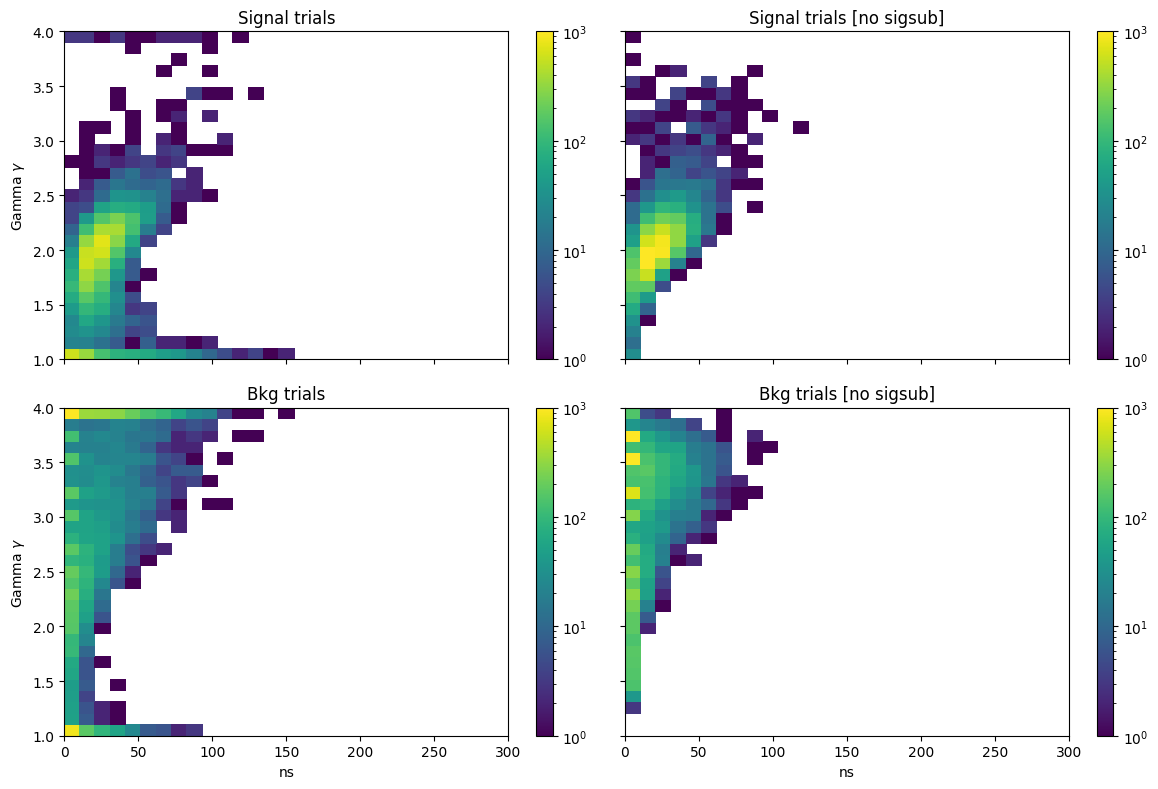

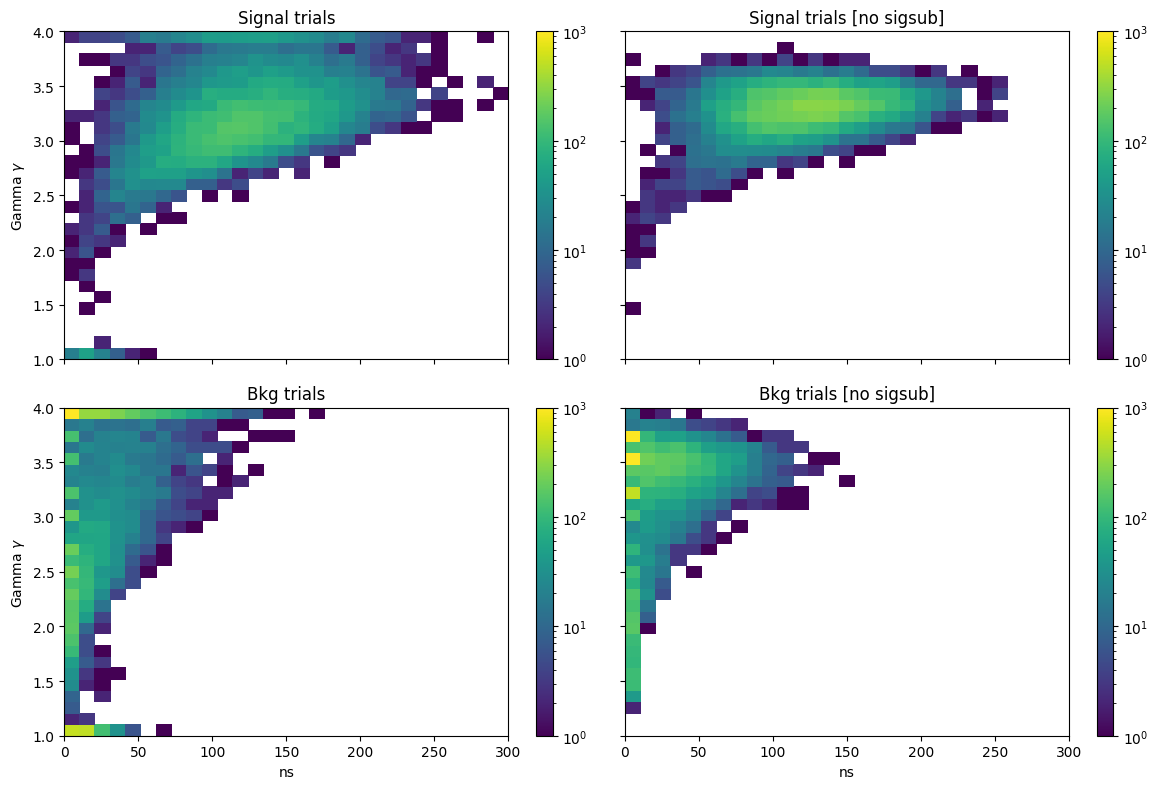

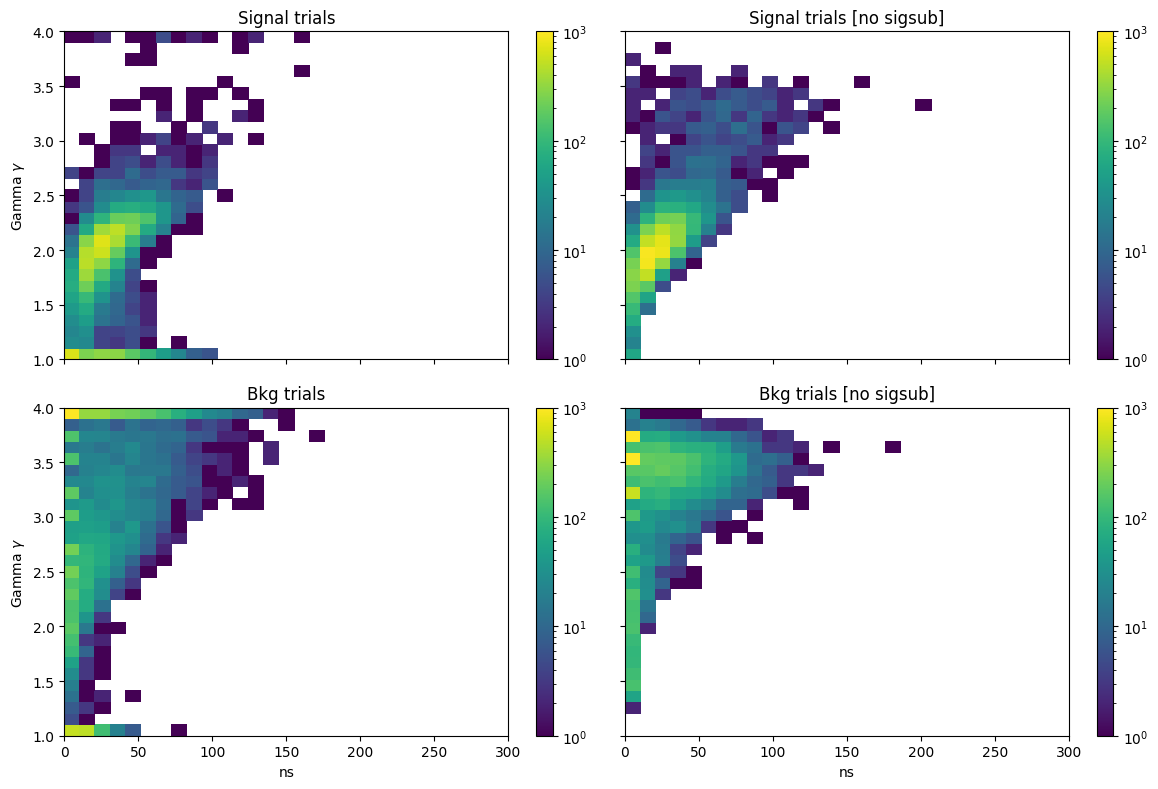

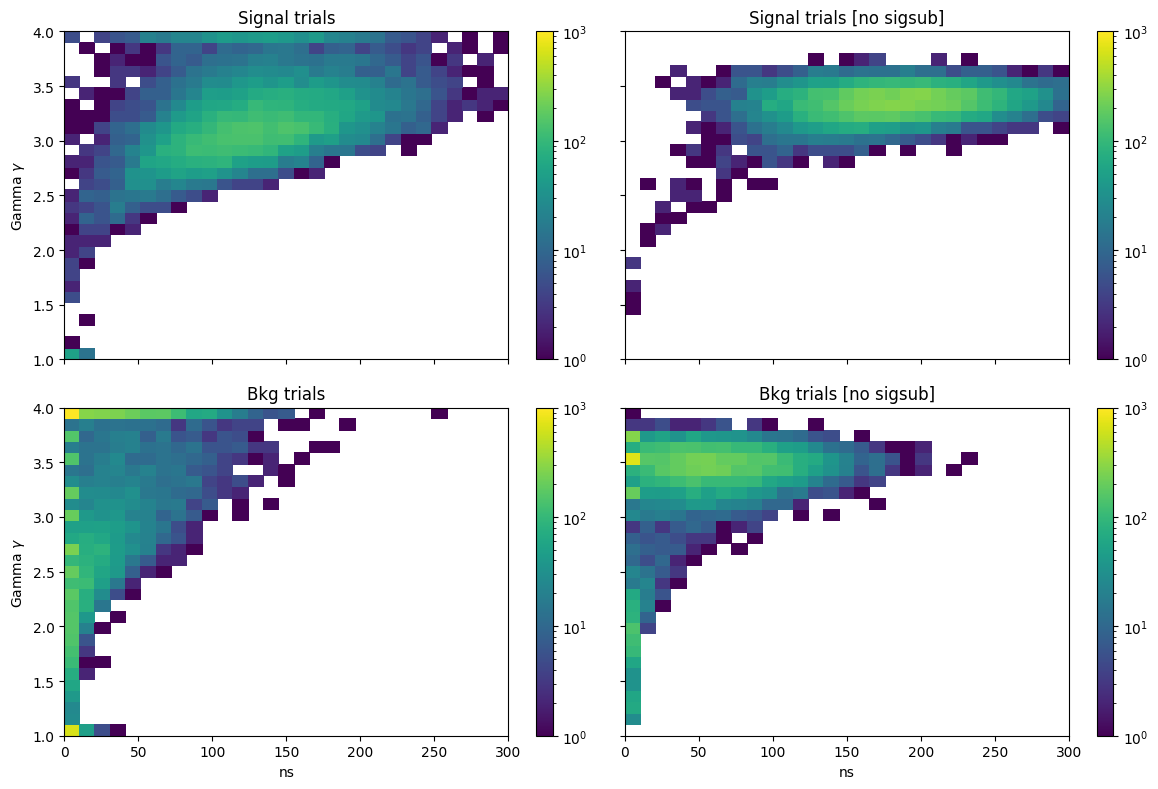

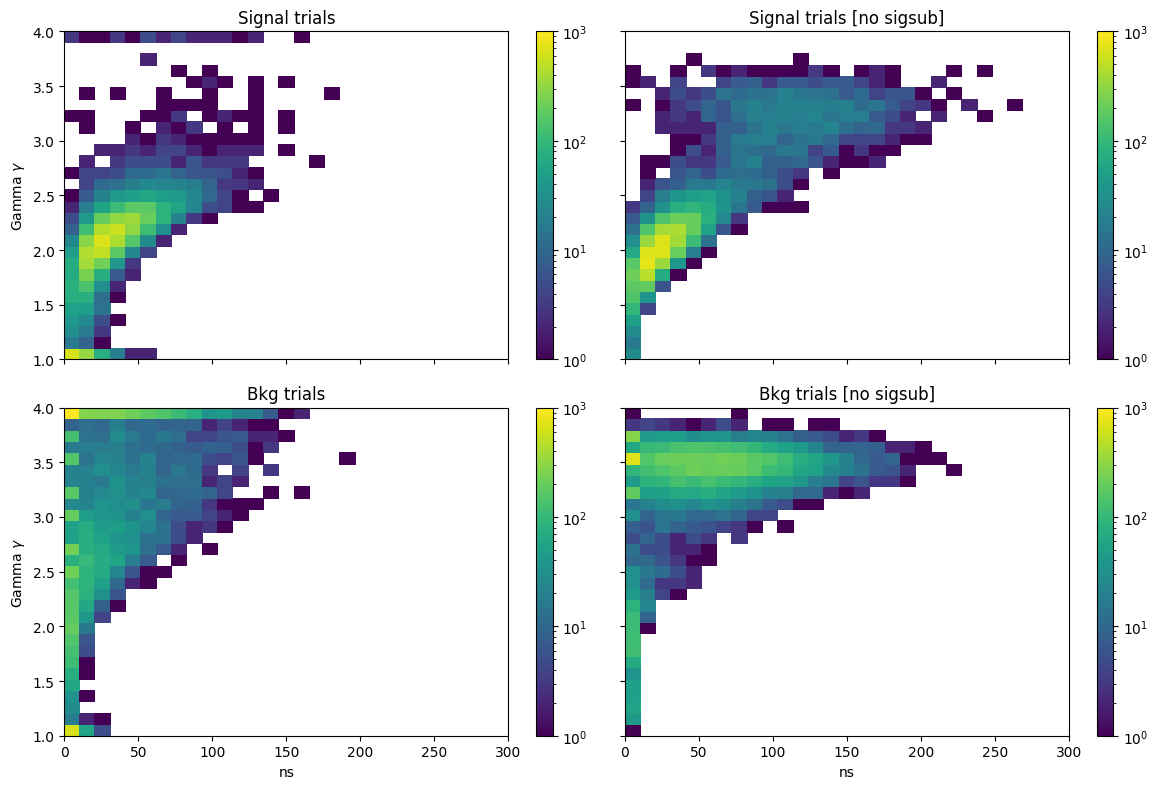

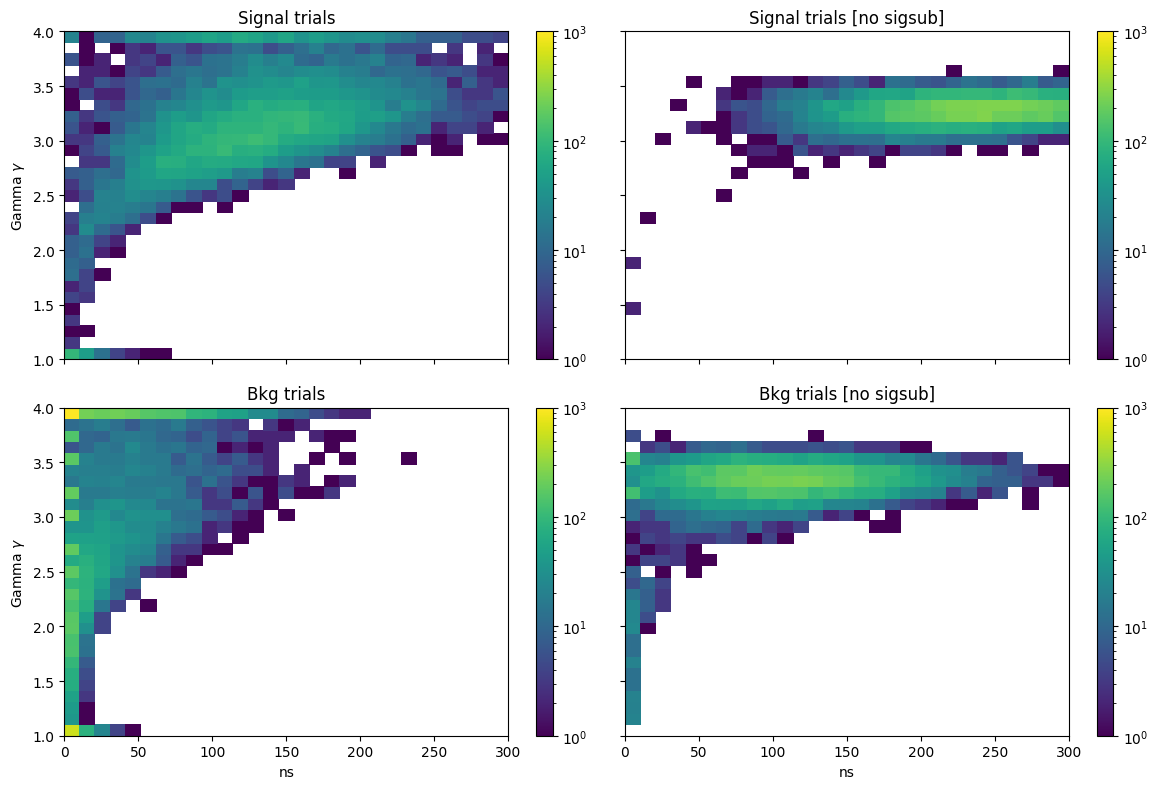

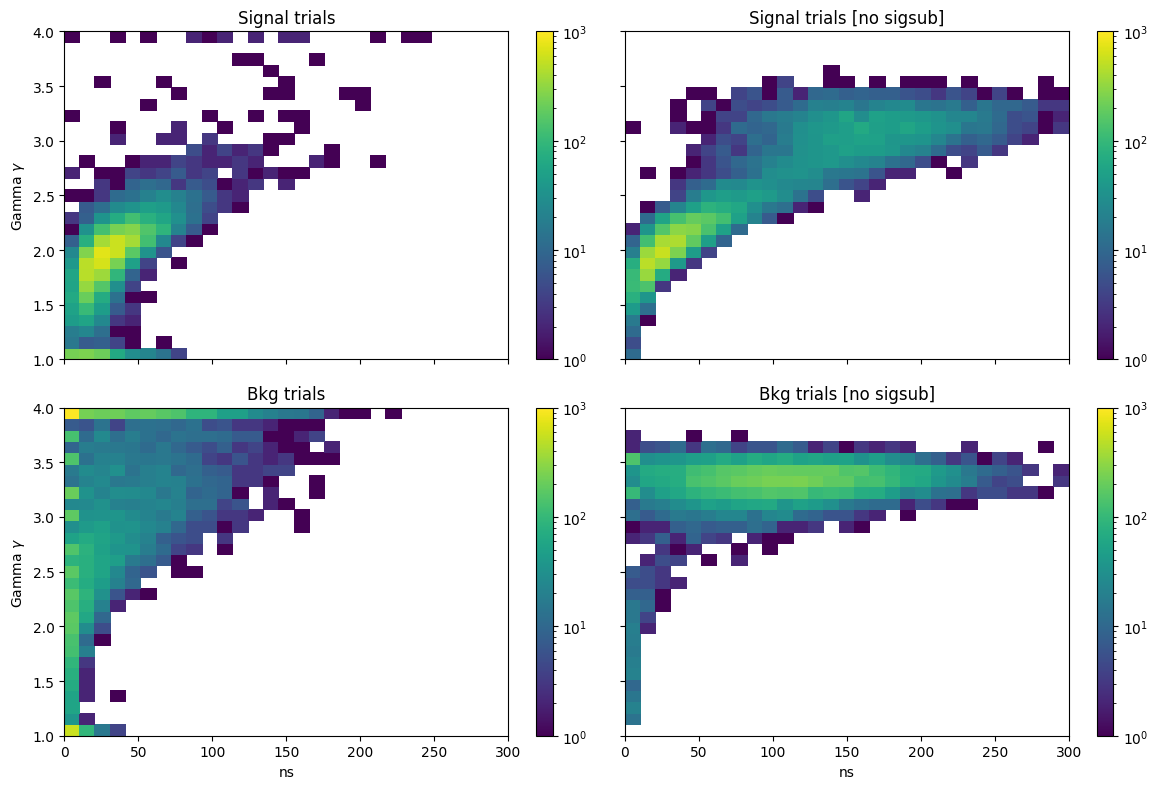

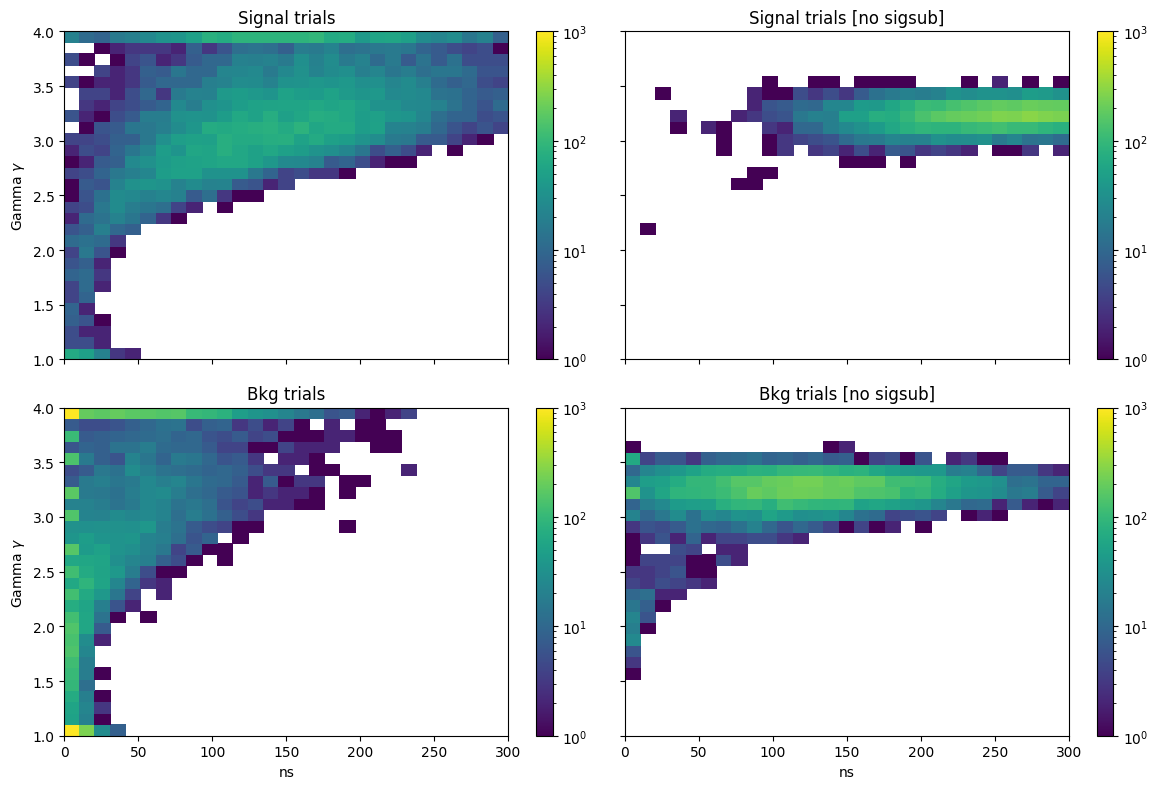

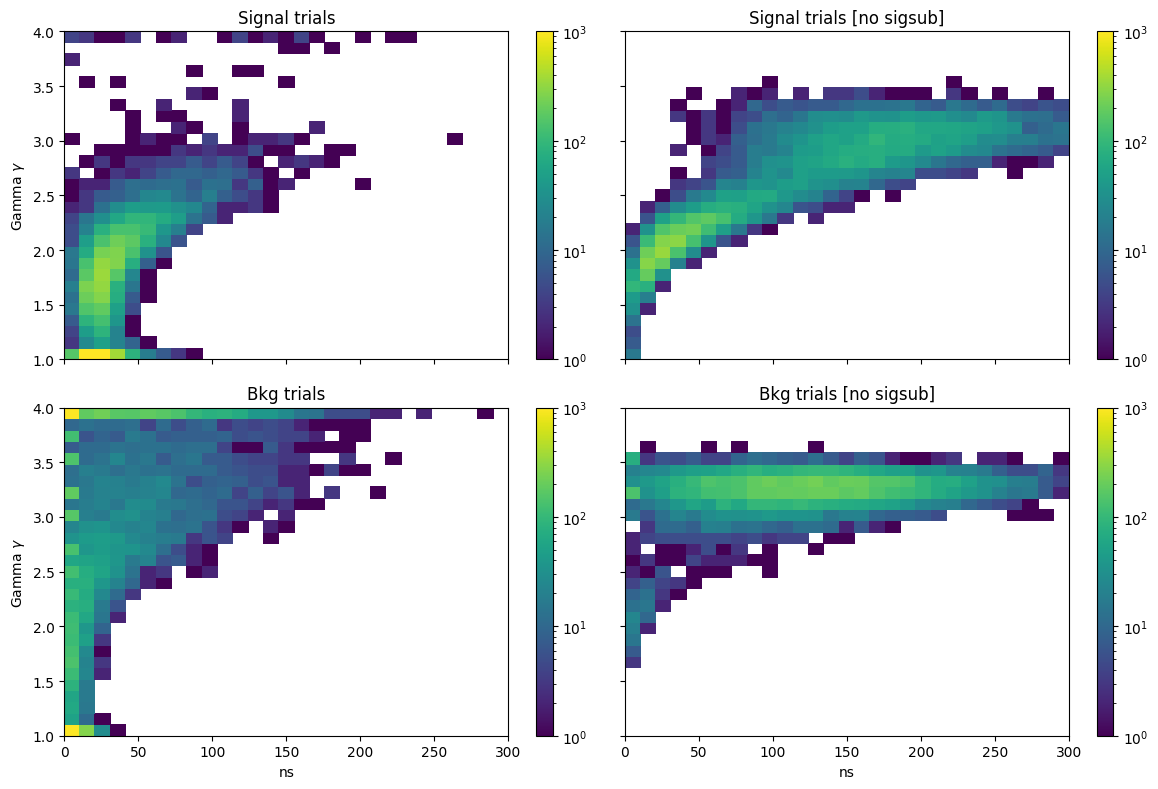

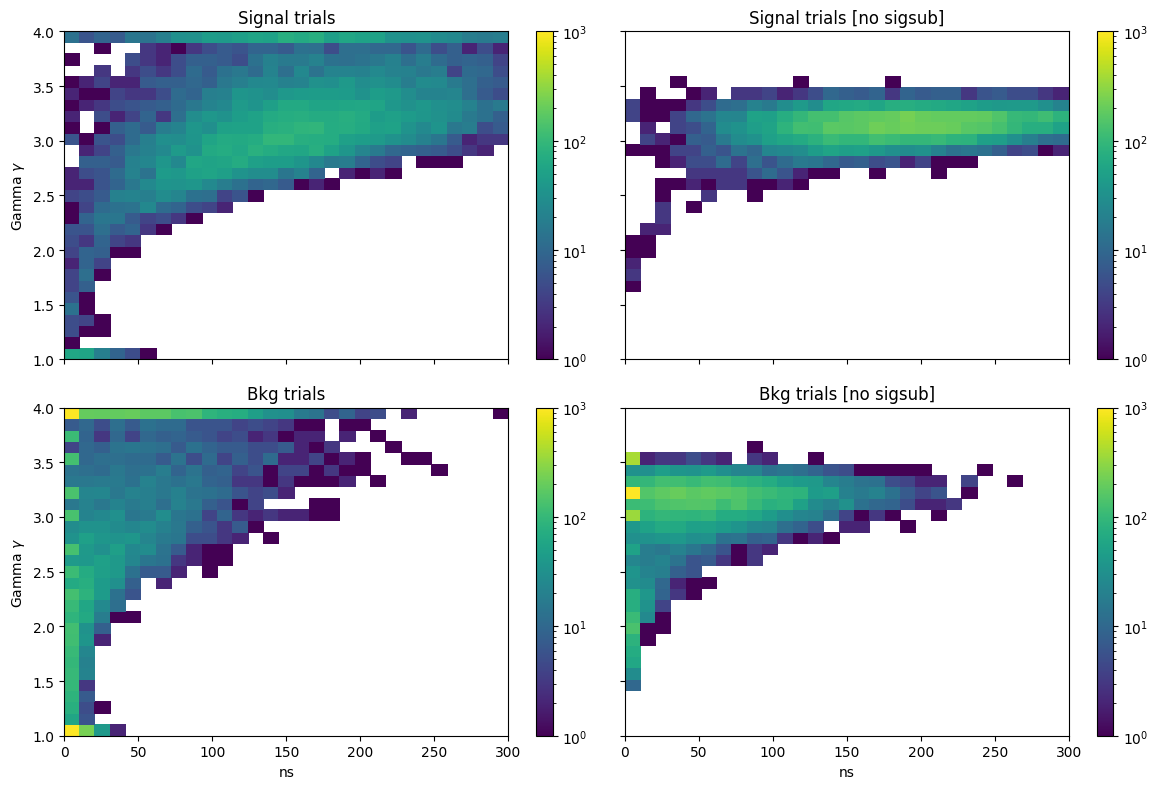

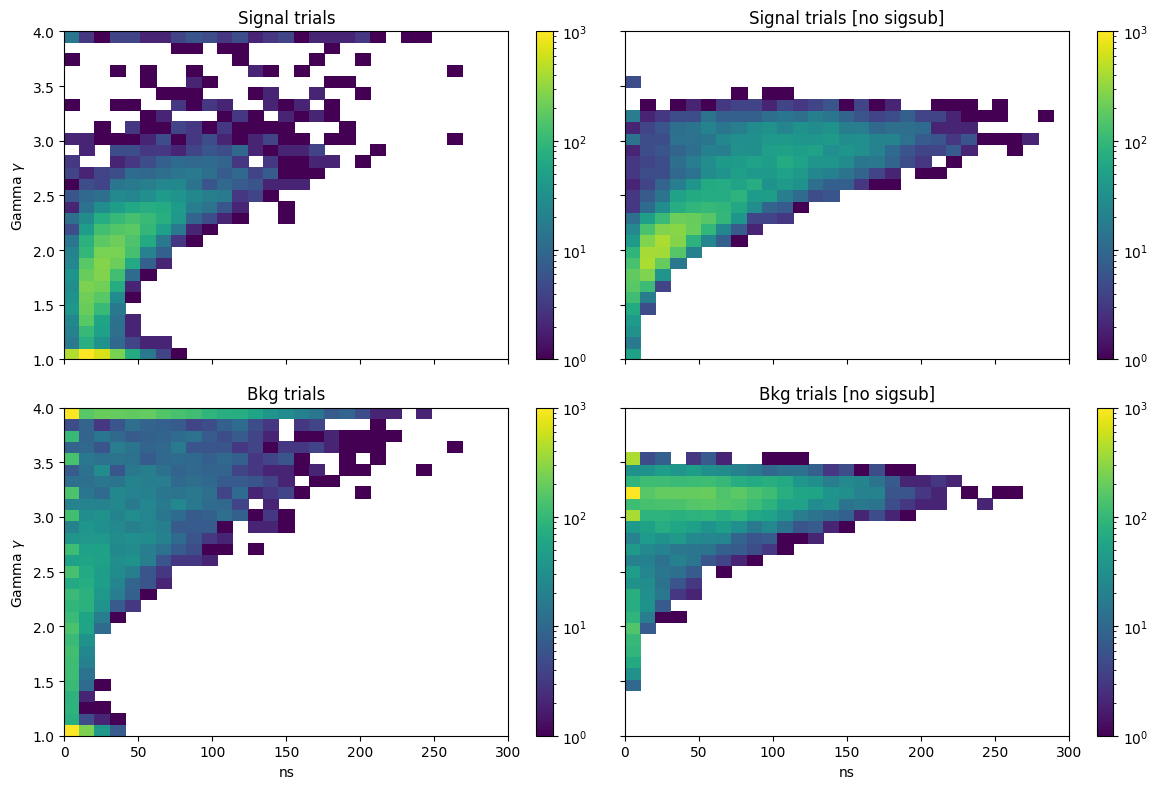

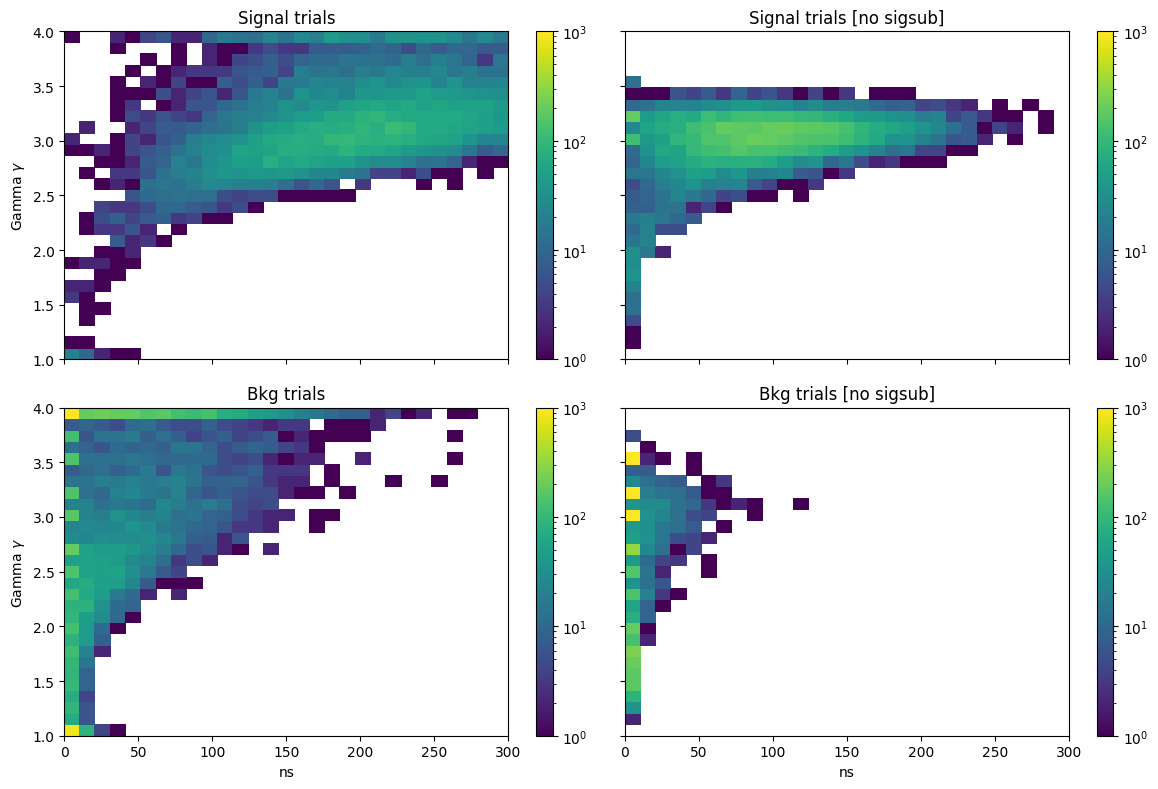

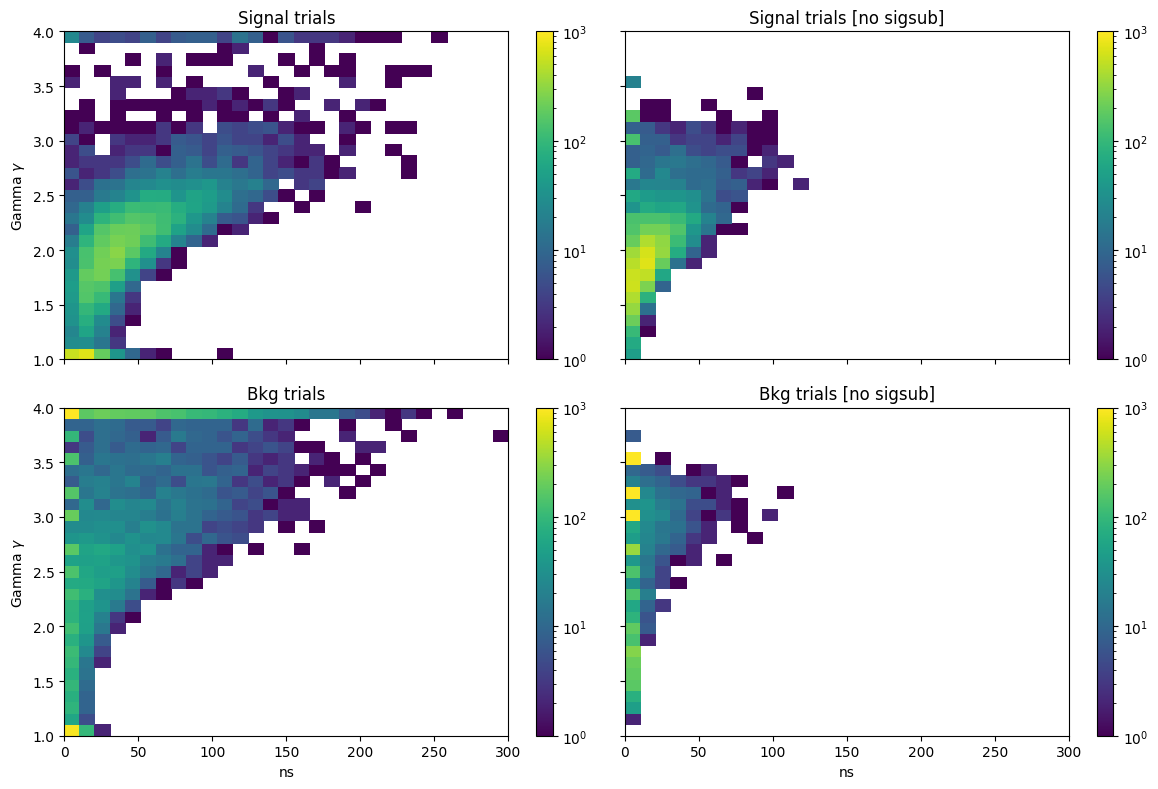

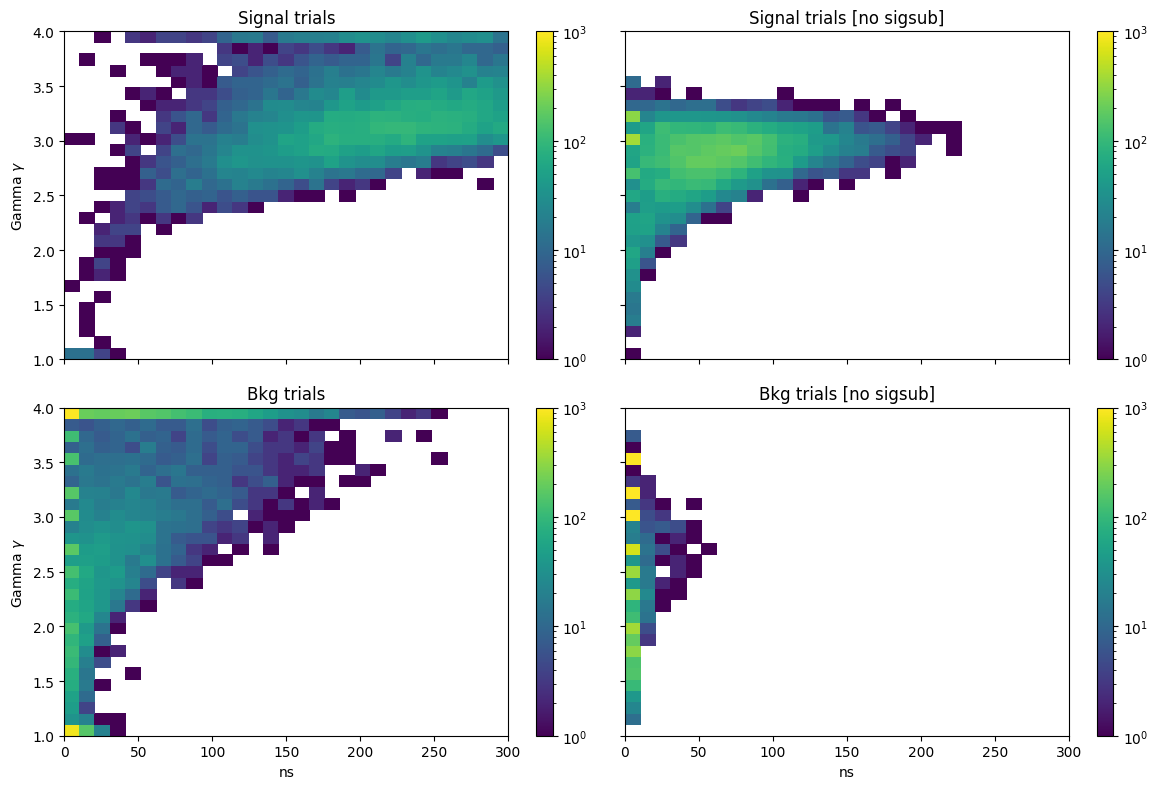

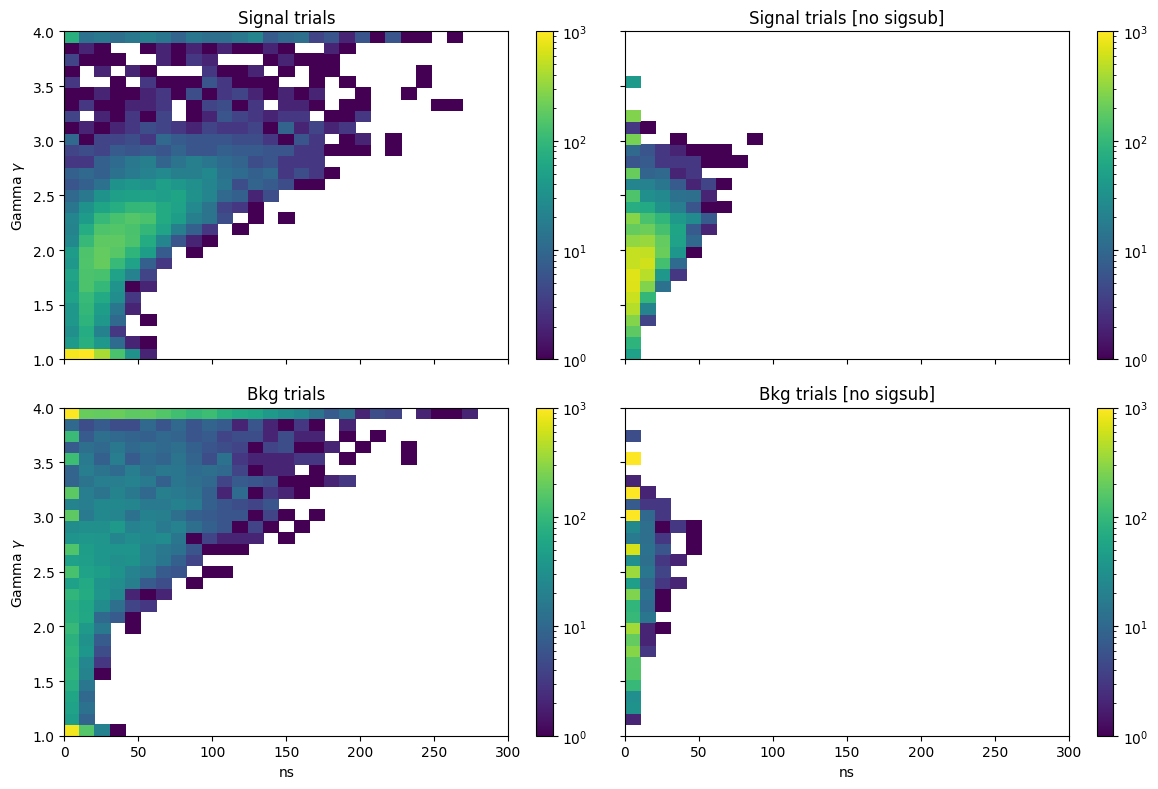

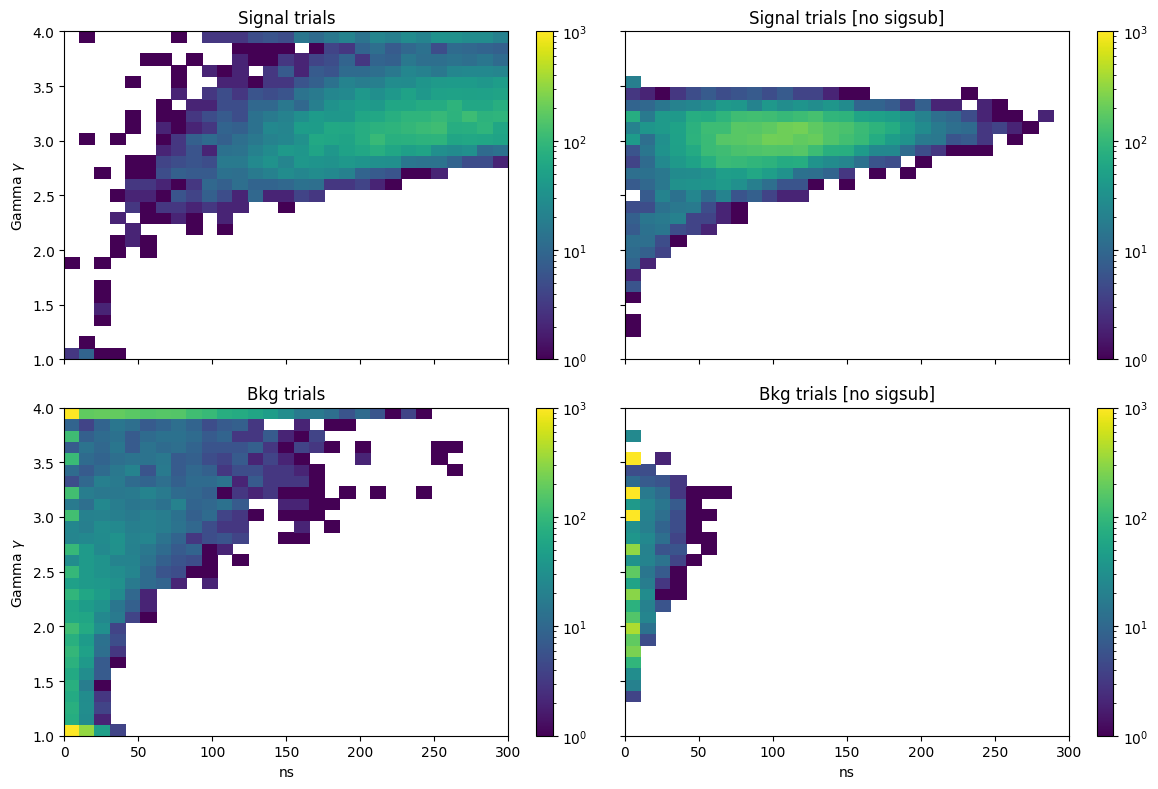

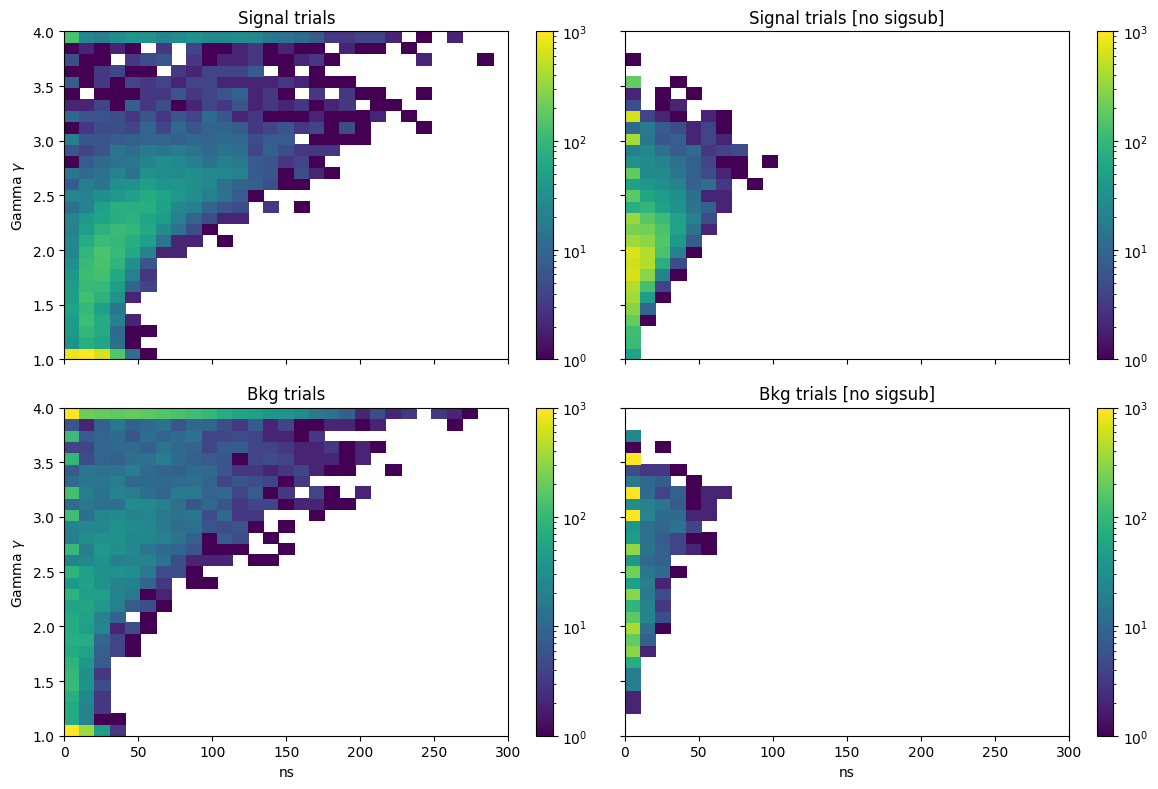

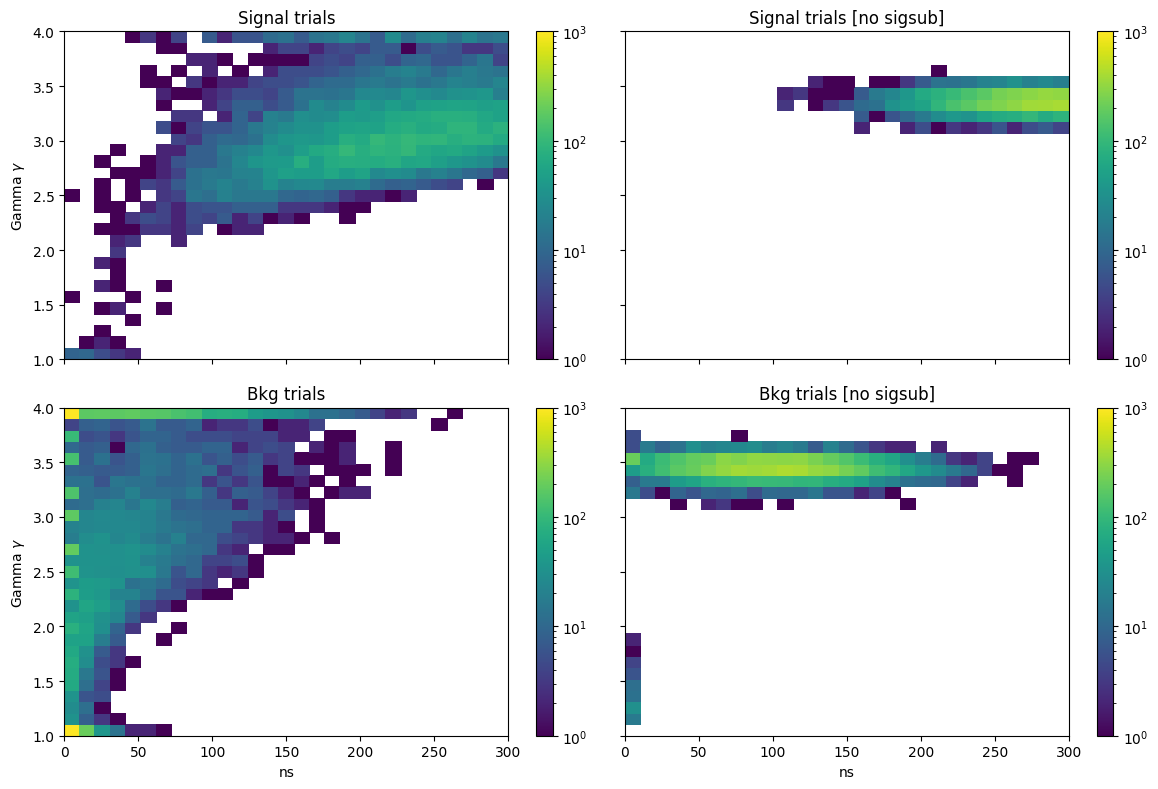

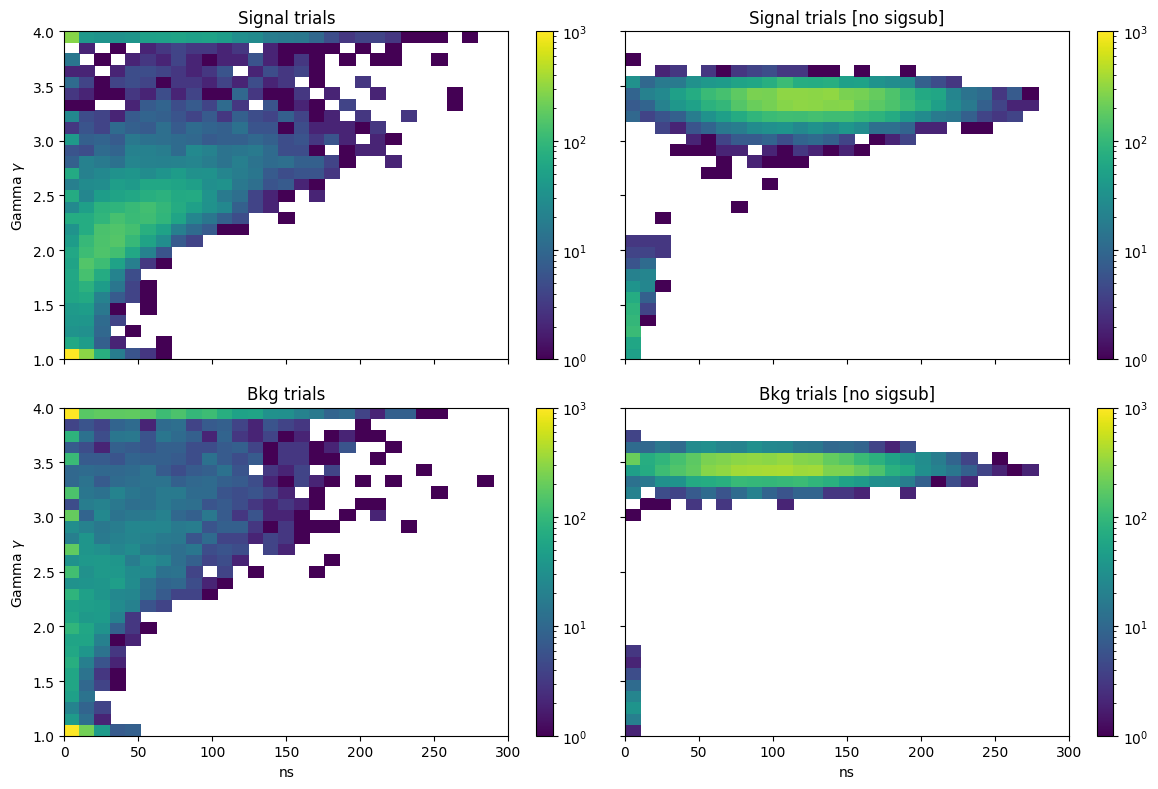

In [77]:

for name, res in results.items():
    res_no_ss = results_no_ss[name]
    print(name)
    print(np.sum(res['sig_trials'].gamma == 1), np.sum(res['sig_trials'].gamma == 4))
    print(np.sum(res['bg_trials'].trials.gamma == 1), np.sum(res['bg_trials'].trials.gamma == 4))
    
    fname = name.replace(' ', '_').replace('[', '_').replace(']', '_').replace('+', '').replace('-', 'm')
    title = r'{} | RA: {:3.3f}° Dec: {:3.3f}°'.format(name, source_dict[name]['ra'], source_dict[name]['dec'])
    
    mask = res['sig_trials'].ns != 0
    mask_bkg = res['bg_trials'].trials.ns != 0
    
    # ---------------------------
    # correlation of ns and gamma
    # ---------------------------
    vmin = 1
    vmax = 1000
    bins = (np.linspace(0, 300, 30), np.linspace(1, 4, 30))
    
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
    
    h, xedges, yedges, im = axes[0, 0].hist2d(
        res['sig_trials'].ns, res['sig_trials'].gamma, bins=bins, 
        vmin=vmin, vmax=vmax, norm=mpl.colors.LogNorm())
    axes[0, 0].set_title('Signal trials')
    plt.colorbar(im, ax=axes[0, 0])
    
    h, xedges, yedges, im = axes[0, 1].hist2d(
        res_no_ss['sig_trials'].ns, res_no_ss['sig_trials'].gamma, bins=bins,
        vmin=vmin, vmax=vmax, norm=mpl.colors.LogNorm())
    axes[0, 1].set_title('Signal trials [no sigsub]')
    plt.colorbar(im, ax=axes[0, 1])
    
    h, xedges, yedges, im = axes[1, 0].hist2d(
        res['bg_trials'].trials.ns, res['bg_trials'].trials.gamma, bins=bins, 
        vmin=vmin, vmax=vmax, norm=mpl.colors.LogNorm()
    )
    axes[1, 0].set_title('Bkg trials')
    plt.colorbar(im, ax=axes[1, 0])
    
    h, xedges, yedges, im = axes[1, 1].hist2d(
        res_no_ss['bg_trials'].trials.ns, res_no_ss['bg_trials'].trials.gamma, bins=bins,
        vmin=vmin, vmax=vmax, norm=mpl.colors.LogNorm(),
    )
    axes[1, 1].set_title('Bkg trials [no sigsub]')
    plt.colorbar(im, ax=axes[1, 1])
    
    axes[0, 0].set_ylabel(r'Gamma $\gamma$')
    axes[1, 0].set_ylabel(r'Gamma $\gamma$')
    axes[1, 0].set_xlabel('ns')
    axes[1, 1].set_xlabel('ns')
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_correlation_ns_gamma.png'))

    # -----------------
    # Significance Plot
    # -----------------
    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(-2, 6, 100)
    ax.hist(res['n_sigma'], bins=bins, histtype='step', color=colors[0])
    ax.hist(res_no_ss['n_sigma'], bins=bins, histtype='step', color=colors[1])
    ax.axvline(np.median(res['n_sigma']), ls='--', color=colors[0], label='Median: {:3.2f}$\cdot \sigma$'.format(np.median(res['n_sigma'])))
    ax.axvline(np.median(res_no_ss['n_sigma']), ls='--', color=colors[1], label='Median: {:3.2f}$\cdot \sigma$ [no sigsub]'.format(np.median(res_no_ss['n_sigma'])))
    ax.legend()
    ax.set_xlabel('$n \cdot \sigma$')
    ax.set_title(title)
    #ax.set_xscale('log')
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_significance.png'))
    
    # -------
    # TS Plot
    # -------
    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(-1, 50, 100)
    ax.hist(res['sig_trials'].ts, bins=bins, histtype='step', label='Signal', color=colors[0])
    ax.hist(res_no_ss['sig_trials'].ts, bins=bins, histtype='step', ls='--', label='Signal [no sigsub]', color=colors[0])
    ax.hist(res['bg_trials'].trials.ts, bins=bins, histtype='step', label='BKG', color=colors[1])
    ax.hist(res_no_ss['bg_trials'].trials.ts, bins=bins, ls='--', histtype='step', label='BKG [no sigsub]', color=colors[1])
    #ax.axvline(np.median(res['sig_trials'].ts), ls='--', color='0.6', label='Median')
    #ax.axvline(np.median(res['bg_trials'].trials.ts), ls='--', color='0.6')
    ax.legend()
    ax.set_xlabel('TS')
    ax.set_yscale('log')
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_ts.png'))
    
    # -------
    # ns Plot
    # -------
    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(0, 500, 100)
    ax.hist(res['sig_trials'].ns, bins=bins, histtype='step', label='Signal', color=colors[0])
    ax.hist(res_no_ss['sig_trials'].ns, bins=bins, histtype='step', ls='--', label='Signal [no sigsub]', color=colors[0])
    ax.hist(res['bg_trials'].trials.ns, bins=bins, histtype='step',label='BKG', color=colors[1])
    ax.hist(res_no_ss['bg_trials'].trials.ns, bins=bins, histtype='step', ls='--', label='BKG [no sigsub]', color=colors[1])
    ax.set_xlabel('ns')
    ax.set_yscale('log')
    ax.set_title(title)
    ax.axvline(res['n_expected'], ls='--', color='0.6', label='Avg. injected ns {:3.1f}'.format(res['n_expected']))
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_ns.png'))
    
    # ----------
    # Gamma Plot
    # ----------
    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(1, 4, 50)
    ax.hist(res['sig_trials'].gamma, bins=bins, histtype='step', label='Signal', color=colors[0])
    ax.hist(res_no_ss['sig_trials'].gamma, bins=bins, ls='--', histtype='step', label='Signal [no sigsub]', color=colors[0])
    ax.hist(res['bg_trials'].trials.gamma, bins=bins, histtype='step', label='BKG', color=colors[1])
    ax.hist(res_no_ss['bg_trials'].trials.gamma, bins=bins, ls='--', histtype='step', label='BKG [no sigsub]', color=colors[1])
    ax.axvline(
        source_dict[name]['gamma'], ls='--', color='0.6', 
        label='Gamma $\gamma=${:3.2f}'.format(source_dict[name]['gamma']),
    )
    ax.legend()
    ax.set_xlabel('gamma')
    ax.set_yscale('log')
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_gamma.png'))

    print()